#Comp 767 Assignment 2 Question 3
##Jonathan Pearce
##260672004
##jonathan.pearce@mail.mcgill.ca
Link: https://colab.research.google.com/drive/12QVoNJ1Y2piHljPHkcsKEoiAdkgJZ6YU

In [23]:
#Assignment general instructions ask for runtimes in google colab
!pip install ipython-autotime

%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.24 s


In [24]:
#Imports
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

time: 2.65 ms


In [25]:
class random_walk(object):

    #initialize parameters for random walk
    def __init__(self,alpha,Lambda,seed):
        #set random seed
        np.random.seed(seed)

        #alpha parameter
        self.alpha = alpha
        #lambda parameter
        self.Lambda = Lambda
        #number of tilings
        self.num_tilings = 10
        #space covered by one tile
        self.delta_s = 0.1
        #discount factor
        self.gamma = 1

        #create offsets
        self.offsets = np.random.uniform(-0.1,0,self.num_tilings)
        #print(self.offsets)

    #action
    def step(self,s_t):
        reward = 0
        done = False
        #take action uniformly from [-0.2,0.2]
        s_t += np.random.uniform(-0.2,0.2)
        #check if we are still in [0,1]
        if s_t < 0 or s_t > 1:
            #If we are outside collect reward and terminate episode
            reward = s_t
            done = True
        #return new state, reward and episode termination boolean
        return s_t, reward, done

    #convert a state to feature vector form
    def state_to_feature(self,s_t):
        #terminal states are zero vectors
        if s_t < 0 or s_t > 1:
            return np.zeros(11*len(self.offsets))

        #Solve for tile index of s_t for all tilings
        tile = np.floor(np.divide(np.subtract(s_t,self.offsets),self.delta_s)).astype(int)
        
        #create binary feature vector with tile indexes
        feature = np.zeros([len(self.offsets),11])
        #Each tiling only has 1 activated tile 
        #Therefore binary feature vector will always have exactly 10 1's 
        for i in range(len(tile)):
            feature[i,tile[i]] = 1

        #convert 2D array to 1D vector
        return feature.flatten()

    #training
    def walk(self):
        #initialize weight vector as zero vector
        w = np.zeros(11*len(self.offsets))

        #train for 25 episodes
        for episodes in range(25):
            #we start at 0.5
            s_t = 0.5
            #get the binary feature vector of s_t
            x_t = self.state_to_feature(s_t)
            #initialize trace vector as zero vector
            z = np.zeros(11*len(self.offsets))
            #episode termination boolean
            done = False
            #Loop until agent leaves [0,1]
            while not done:
                #take step in environment
                s_t_1, reward, done = self.step(s_t)
                #get the binary feature vector of s_t_1
                x_t_1 = self.state_to_feature(s_t_1)
                #calculate state values
                #dot product of feature vector of state and weight vector
                v_t = np.dot(w,x_t)
                v_t_1 = np.dot(w,x_t_1)

                #update the accumulating trace 
                z = ((self.gamma * self.Lambda * z) + x_t)

                #compute delta
                delta = (reward + (self.gamma * v_t_1 - v_t))

                #update weight vector
                w = (w + (self.alpha * delta * z))

                #move state and feature vector to 
                x_t = x_t_1
                s_t = s_t_1
        
        #return weight vector
        return w

    #compute root mean squared error
    def compute_RMSE(self,w):
        #sample 21 different points in the interval [0,1], evenly spaced at 0.05
        #The correct predictions are equal to the position
        x = np.arange(0,1.05,0.05)
        #root mean squared error
        RMSE = 0
        #iterate through 21 points (states)
        for i in range(21):
            #get the feature vector of the state
            feature = self.state_to_feature(x[i])
            #compute the estimated value of the state according to estimated weight vector
            value = np.dot(feature,w)
            #update root mean square error
            RMSE += np.power(value-x[i],2)

        #divide by n (here n=21) and take square root
        return np.sqrt((RMSE/21.0))

    #helper function for debugging 
    def debug_values(self,w):
        x = np.linspace(0,1,21)
        for i in range(21):
            feature = self.state_to_feature(x[i])
            value = np.dot(feature,w)
            print(value)

time: 122 ms


#Random Walk Experiment
For our experiment we implemented TD($\lambda$) with accumulating traces and tile coding. We tested TD($\lambda$) on a continuous random walk environment on $[0,1]$, with initial state at 0.5, and movements selected uniformly from $[-0.2,0.2]$. We tested TD($\lambda$) across multiple $\alpha$ and $\lambda$ values to examine how performane varied with different parameter combinations. For each pair of $\alpha$ and $\lambda$ values, TD($\lambda$) was run for 25 episodes before evaluating the linear function approximator with the root mean squared error metric. This process was repeated across 50 different random seeds for each pair of $\alpha$ and $\lambda$ values. The results of our experiment are below.


In [26]:
#parameters

#50 random seeds
seeds = np.arange(0,50)
#alpha values 
alpha = np.array([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
#scale alpha values proportionally to number of tilings
#here we will scale to exactly the number of tilings (10)
#this is discussed on page 217-218 of Sutton and Barto textbook
alpha = np.divide(alpha,10.0)
#lambda values
Lambda = np.array([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

#arrays to store averages and standard deviations
avg = np.zeros([len(Lambda),len(alpha)])
std = np.zeros([len(Lambda),len(alpha)])

#Run tests
for i in range(len(Lambda)):
    for j in range(len(alpha)):
        #array to collect RMSE from each run
        RMSE_stats = np.zeros(len(seeds))
        for k in range(len(seeds)):
            #create random walk, will generate random offsets
            rw = random_walk(alpha[j],Lambda[i],seeds[k])
            #run the training procedure
            w = rw.walk()
            #test the accuray of our function approximation and add to data collection
            RMSE_stats[k] = rw.compute_RMSE(w)

        #add
        avg[i,j] = np.mean(RMSE_stats)
        std[i,j] = np.std(RMSE_stats)

time: 1min 23s


In [27]:
#compute best result
i,j = np.unravel_index(avg.argmin(), avg.shape)
print("Best result")
print('\u03BB = ', Lambda[i])
print('\u03B1 = ', alpha[j])
print('RMSE = ',avg[i,j])
print('std = ', std[i,j])

Best result
λ =  0.6
α =  0.03
RMSE =  0.16461249785273777
std =  0.0668080435111763
time: 7.34 ms


In [28]:
#we will plot x-axis as alpha x number of tilings (10) 
#Similar to Figure 10.4 on page 248 of Sutton and Barto textbook
alpha = np.multiply(alpha,10)

time: 2.63 ms


#Discussion
For low values of $\alpha$ (e.g. 0.1/10 and 0.2/10) it appears that TD($\lambda$) learns most effectivly with high values of $\lambda$. TD(0.9) achieves its lowest RMSE at $\alpha$ = 0.1/10 and TD(0.8) as well as TD(0.7) achieve their lowest RMSE at $\alpha$ = 0.2/10. However these strong results for TD(0.9), TD(0.8) and TD(0.7) at low $\alpha$ values are constrasted by very poor results when $\alpha$ > 0.2/10, $\alpha$ > 0.3/10 and $\alpha$ > 0.4/10 respectively, in fact all 3 of these methods quickly begin performing worse than when no training is done ($\alpha$ = 0). It appears that high $\lambda$ values produced strong results at low $\alpha$ values and very poor results at higher $\alpha$ values. On the other hand lower $\lambda$ values appear to be more reliable across any value of $\alpha$. Low $\lambda$ values (e.g. 0.0,0.1,0.2) do not achieve the best RMSE in the entire experiment, however when $\alpha$ > 0.6/10 they are the strongest methods. Further they are very consistent, the second plot below shows that TD(0) and TD(0.1) have stable standard deviations for all values of $\alpha$, where as TD(0.6) begins to have more variance for higher $\alpha$ values and TD(0.9) becomes completely unreliable when $\alpha$ > 0.4/10. The best performing method was TD(0.6) at $\alpha$ = 0.3/10 (although many other methods were very close), this result agrees with other random walk results in the textbook and what we have discussed in class (on another random walk example), that TD($\lambda$) peforms best on average with intermediate values of $\lambda$ and $\alpha$ 

1st Graph: Presents full results across all $\lambda$ and $\alpha$ pairs.

2nd Graph: Presents the same information as 1st graph but with a subset of $\lambda$ values. The purpose of this graph is to make it easier to analyze the variance of different TD($\lambda$) methods across $\alpha$ values.

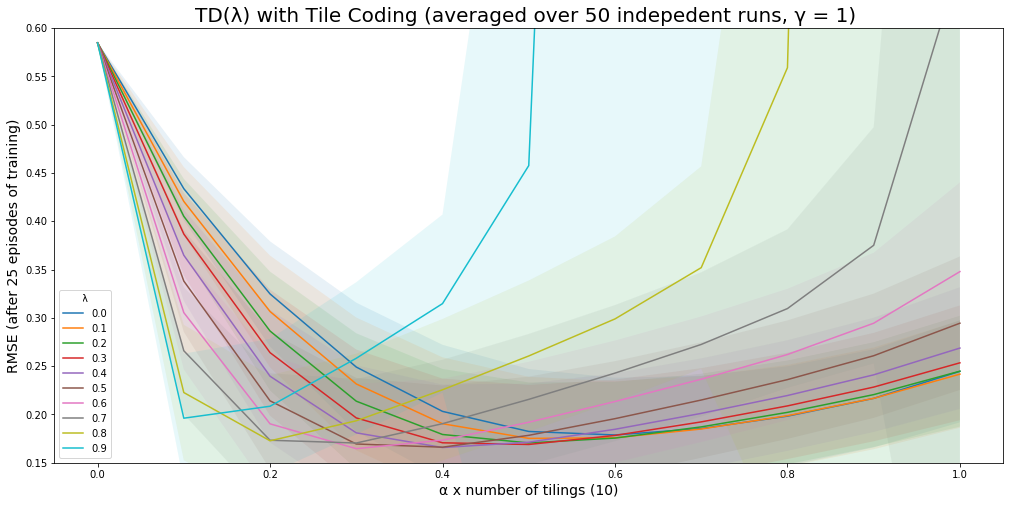

time: 563 ms


In [29]:
plt.figure(figsize=(17,8))
plt.ylim(0.15,0.6)

for i in range(len(Lambda)):
    plt.plot(alpha,avg[i,:],label=Lambda[i])
    plt.fill_between(alpha,avg[i,:]-std[i,:],avg[i,:]+std[i,:],alpha=0.1)
    

plt.title('TD(\u03BB) with Tile Coding (averaged over 50 indepedent runs, \u03B3 = 1) ', fontsize=20)
plt.xlabel('\u03B1 x number of tilings (10)',fontsize=14)
plt.ylabel('RMSE (after 25 episodes of training)',fontsize=14)
plt.legend(loc='lower left',title='\u03BB')
plt.show()

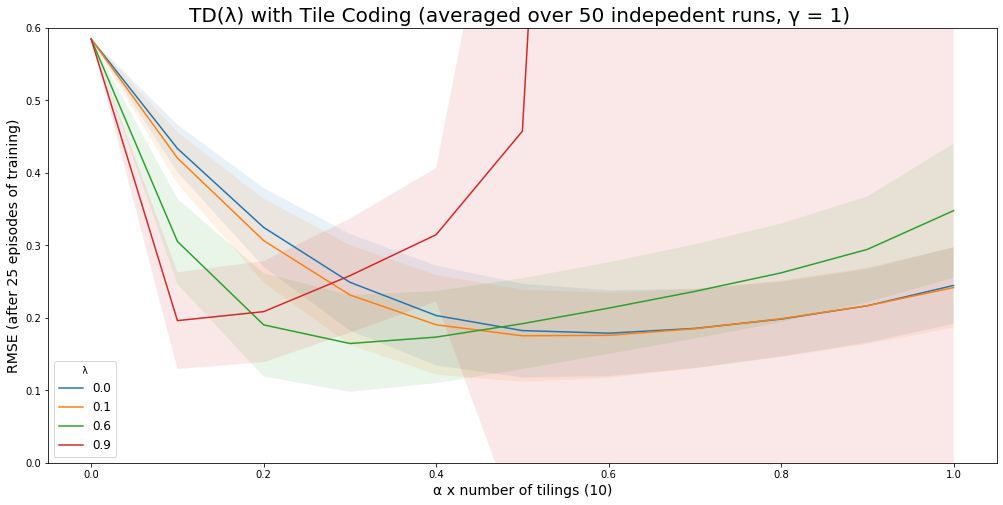

time: 437 ms


In [30]:
plt.figure(figsize=(17,8))
plt.ylim(0,0.6)

indexes = [0,1,6,9]

for i in indexes:
    plt.plot(alpha,avg[i,:],label=Lambda[i])
    plt.fill_between(alpha,avg[i,:]-std[i,:],avg[i,:]+std[i,:],alpha=0.1)
    

plt.title('TD(\u03BB) with Tile Coding (averaged over 50 indepedent runs, \u03B3 = 1) ', fontsize=20)
plt.xlabel('\u03B1 x number of tilings (10)',fontsize=14)
plt.ylabel('RMSE (after 25 episodes of training)',fontsize=14)
plt.legend(loc='lower left',title='\u03BB',fontsize=12)
plt.show()